In [1]:
%matplotlib inline
from IPython.display import clear_output
import time
from Environments.environments import all_envs, get_all_avail_envs
from Agents.dqn_agent import DQN_Agent
from Agents.ppo_agent import PPO_Agent
from Models import fc, rnn
import matplotlib.pyplot as plt
import torch
import utils
from Curriculum_managers.random_curriculum import Random_Curriculum
from Curriculum_managers.paired_curriculum import PAIRED_Curriculum
from Curriculum_managers.paired_curriculum_no_regret import PAIRED_Curriculum_no_regret
from Curriculum_managers.paired_curriculum_no_regret_teacher_entropy import PAIRED_Curriculum_no_regret_entropy
# from Curriculum_managers.paired_curriculum_extented import  PAIRED_Curriculum_entropy
import plotly.express as px
# os.environ["LANG"]="en_US"


In [2]:
device = utils.init_torch()
def get_load_str(base_path, i, name):
    return base_path + f"/_{i}_{name}.ckpt"
    # "/home/nitsan57/Documents/Study/CDM_torch/results/random_agent_weights/MiniAdversarialEnv/_19999_trainee.ckpt"

In [3]:
env_names = get_all_avail_envs()
env_names

['SingleTaxiEnv',
 'FrozenLakeEnv',
 'AdversarialEnv',
 'ReparameterizedAdversarialEnv',
 'MiniAdversarialEnv',
 'MiniReparameterizedAdversarialEnv',
 'NoisyAdversarialEnv',
 'MediumAdversarialEnv',
 'GoalLastAdversarialEnv',
 'MiniGoalLastAdversarialEnv']

In [4]:
env = all_envs['MiniAdversarialEnv'](random_reset_loc=False)
n_actions = env.action_space.n
obs_shape = env.observation_space.shape
gen_obs_shape = env.get_generator_observation_space().shape
gen_action_dim = env.get_generator_action_space().n
# gen_obs_shape = env.get_generator_observation_space()


In [5]:
# env = gym.envs.make("CartPole-v1")
# n_actions = env.action_space.n
# obs_shape = env.observation_space.shape

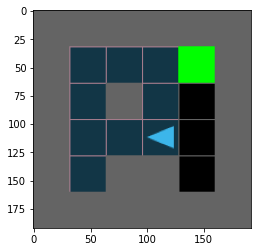

In [6]:
plt.imshow(env.render('rgb_array'))
plt.show()

In [7]:
# r_agent = DQN_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.3, eps_dec=0, lr=0.001, model=rnn.RNN)
# r_rewards = r_agent.train_episodial(env, 100000)
# r_agent.close_env_procs()

### Random curriculum train single example:

In [8]:
# agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.3, eps_dec=0, lr=0.001, model=rnn.RNN)
# teacher_agent = PPO_Agent(gen_obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.3, eps_dec=0, lr=0.001, model=rnn.RNN)
r_agent = DQN_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.3, eps_dec=0, lr=0.0001, model=rnn.RNN)
r_teacher = Random_Curriculum(env, trainee=r_agent)
r_rewards = r_teacher.teach(n_iters=5000, n_episodes=8)

R:00000.09: 100%|██████████| 5000/5000 [03:54<00:00, 21.31it/s]


In [ ]:
# trainee_path = get_load_str("/home/nitsan57/Documents/Study/CDM_torch/results/random_agent_weights/MiniAdversarialEnv/", 19999,"trainee")
# r_teacher.load_models({'trainee' : trainee_path})
# r_agent = r_teacher.trainee

In [ ]:
fig = px.line(x=range(len(r_rewards)), y=r_rewards, title='Train rewards')
fig.show()

In [10]:
import numpy as np
fig = px.line(x=range(len(np.convolve(r_rewards, np.ones(100)/100,mode='valid'))), y=np.convolve(r_rewards, np.ones(100)/100, mode='valid'), title='Train rewards')
fig.show()

# PAIRED CURRICULUM

In [9]:
# p_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
# teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
p_agent = DQN_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.8, eps_dec=0, lr=0.0001, model=rnn.RNN)
teacher_agent = DQN_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=1, eps_dec=0.0001, lr=0.001, model=rnn.RNN)
p_teacher = PAIRED_Curriculum(env, teacher_agent=teacher_agent ,trainee=p_agent)
# p_rewards = p_teacher.teach(n_iters=5000, n_episodes=8)

In [10]:
e = p_teacher.create_envs(1)[0]

In [ ]:
plt.imshow(e.render('rgb_array'))

In [ ]:
pnr_agent = DQN_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.8, eps_dec=0, lr=0.0001, model=rnn.RNN)
teacher_agent_nr = DQN_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=1, eps_dec=0.0001, lr=0.001, model=rnn.RNN)
pnr_teacher = PAIRED_Curriculum_no_regret(env, teacher_agent=teacher_agent_nr ,trainee=pnr_agent)
pnr_rewards = pnr_teacher.teach(n_iters=5000, n_episodes=8)

In [17]:
trainee_path = "/home/nitsan57/Documents/Study/CDM_torch/results/paired_agent_weights/MiniAdversarialEnv/_19999_trainee.ckpt"
anta_path = "/home/nitsan57/Documents/Study/CDM_torch/results/paired_agent_weights/MiniAdversarialEnv/_19999_antagonist.ckpt"
teacher_path = "/home/nitsan57/Documents/Study/CDM_torch/results/paired_agent_weights/MiniAdversarialEnv/_19999_teacher.ckpt"
p_teacher.load_models({'trainee': trainee_path, 'antagonist': anta_path, 'teacher': teacher_path})
p_agent = p_teacher.trainee

In [ ]:
fig = px.line(x=range(len(p_rewards)), y=p_rewards, title='Train rewards')
fig.show()

# PARIED_ENTROPY

In [ ]:
pe_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pe_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pe_teacher = PAIRED_Curriculum_no_regret(env, teacher_agent=pe_teacher_agent ,trainee=pe_agent)
pe_rewards = pe_teacher.teach(n_iters=20000, n_episodes=8)

# PARIED_ENTROPY_NO_REGRET

In [5]:
pen_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pen_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=512, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pen_teacher = PAIRED_Curriculum_no_regret_entropy(env, teacher_agent=pen_teacher_agent ,trainee=pen_agent)
pen_rewards = pen_teacher.teach(n_iters=25000, n_episodes=8)

  0%|          | 0/25000 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

# RESULTS CHECK

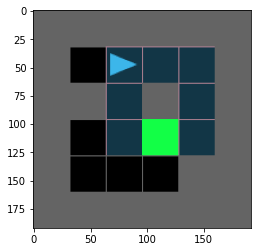

In [19]:
env.reset_random()
plt.imshow(env.render('rgb_array'))
plt.show()

In [8]:
agent = r_agent

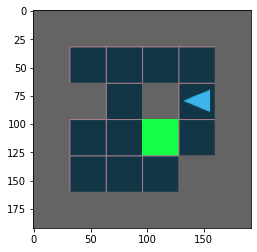

5 0 True
evaluation episode: 0 R: 0


In [20]:
agent.set_eval_mode()
for i in range(1):
    obs = env.reset()
    # break
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        clear_output(wait=True)
        plt.imshow(env.render('rgb_array'))
        plt.show()
        # env.render(mode='rgb_array')
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        print(action, r, done)

        R += r
        t += 1
        reset = t == 500
        time.sleep(0.1)
        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)